# Job characteristics estimation
Based on the post-processed log entries from the `job_logs_cleanup.ipynb` notebook, single job characteristics such as waiting time, job duration, and CPU and memory resource usage are estimated. Also, for each job the 95% range of logged CPU and memory resource usage is calculated, which might help to come up with a job interactivity score. These characteristics will not be statistically analysed here, but in follow-up Jupyter notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read cleaned-up job logs

In [2]:
job_logs = pd.read_parquet('data/job_logs.parquet')

In [3]:
job_logs

,Identifier,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
0,50f38293dabf53e9,clbigmem,RUN,45.40000,10000.86,560223.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
1,1cadd9af115874fc,clbigmem,RUN,66.43000,1461501.36,181504.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
2,84b513a49a615a33,clbigmem,RUN,44.20000,2973694.55,93235.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
3,817f139219e72642,clbigmem,RUN,2.01000,1166604.28,36574.0,3.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
4,fc3ffa2fca1e77be,clbigmem,RUN,30.28000,138055.86,4353.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...,...
8962532,c55584ba43546979,clmedium,RUN,0.27725,13.82,4567.0,1.0,2020-10-07 16:10:14+02:00,2020-09-25 17:48:48+02:00
8962533,935289e122c1bb41,clmedium,RUN,0.73150,3559.43,3573.0,1.0,2020-10-07 16:10:14+02:00,2020-09-25 17:48:48+02:00
8962534,11701d8a036ab2ac,clmedium,QUE,0.00000,0.00,0.0,2.0,2020-10-07 16:10:14+02:00,2020-09-25 17:48:48+02:00
8962535,a2110a3c4c32991e,clmedium,RUN,0.78715,24.89,2118.0,1.0,2020-10-07 16:10:14+02:00,2020-09-25 17:48:48+02:00


In [4]:
orig_log_length = job_logs.shape[0]

In [5]:
orig_unique_jobs = job_logs['Identifier'].unique().shape[0]

In [6]:
orig_log_length, orig_unique_jobs

(8962537, 133356)

In [6]:
orig_log_length, orig_unique_jobs

(3785550, 79257)

## Drop incompletely sampled jobs
As waiting and run times, as well as CPU and memory resources cannot be accurately estimated for jobs that already existed at the beginning and the termination of a log cycle. This operation reduces the total job number close to the beginning and end of a log cycle, which should be kept in mind especially for time series analyses.

In [7]:
drop_these = job_logs.set_index('Time').loc[
    job_logs.groupby(['Cycle'])['Time'].min().to_list()
]['Identifier'].to_list()

In [8]:
drop_these = drop_these + job_logs.set_index('Time').loc[
    job_logs.groupby(['Cycle'])['Time'].max().to_list()
]['Identifier'].to_list()

In [10]:
job_logs = job_logs.set_index('Identifier').drop(index=drop_these).reset_index()

In [11]:
100*job_logs.shape[0]/orig_log_length, 100*job_logs['Identifier'].unique().shape[0]/orig_unique_jobs

(90.96776950544249, 97.17972944599418)

## Drop jobs that don't report resources
As we don't learn anything about these anyway.

In [12]:
subset = (job_logs.set_index('Identifier')['STT']=='RUN') & \
  job_logs.set_index('Identifier')['Elapse'].isna()

In [13]:
drop_these = job_logs.set_index('Identifier')[subset].index.unique()

In [14]:
with pd.option_context('display.max_rows', None):
    display(job_logs.set_index('Identifier').loc['75bc9d7758dce369'])

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 11:43:16+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 11:54:09+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:04:51+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:15:40+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:26:27+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:37:12+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:48:39+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 12:59:22+01:00,2020-02-06 19:52:28+01:00
75bc9d7758dce369,clexpres,RUN,NaN,NaN,NaN,1.0,2020-02-07 13:10:07+01:00,2020-02-06 19:52:28+01:00


In [15]:
job_logs = job_logs.set_index('Identifier').drop(index=drop_these).reset_index()

In [16]:
100*job_logs.shape[0]/orig_log_length, 100*job_logs['Identifier'].unique().shape[0]/orig_unique_jobs

(90.84004897274065, 97.13623683973725)

## Drop multi-queue jobs

For jobs assigned to more than one batch class, the estimates that are calculated below won't be accurate. As there are not many multi-queue jobs (about 0.1% of the job entries), we simply decide to drop them for the job characteristics analysis.

Note on user behaviour: Moving jobs to a different batch class needs manual user intervention with a specific batch scheduler command. Given the very low number of jobs with such a characteristic (but knowing that users likely move their jobs if they experience unacceptable waiting times), we can speculate that many users probably move their jobs to a different queue not by using the corresponding batch scheduler command, but rather by simply deleting and resubmitting a job. To keep the multi-queue jobs, we could split the job by the queue name and treat them as single jobs that never ran, and a job submitted at a later point that then might ran. However, previouly accumulated waiting time could have an influence on the job priority assigned by the scheduler and thus on the estimate waiting time, so this might not be correct to do. As already stated, these jobs are simply dropped for now.

In [17]:
batch_class_number = job_logs.groupby('Identifier')['Queue'].nunique()

In [18]:
drop_these = batch_class_number.index[batch_class_number > 1]

In [20]:
with pd.option_context('display.max_rows', 18):
    display(job_logs.set_index('Identifier').loc['15f8e91ac6df1c5a'])

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
15f8e91ac6df1c5a,clmedium,QUE,0.00,0.00,0.0,4.0,2020-05-22 00:33:10+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clmedium,QUE,0.00,0.00,0.0,4.0,2020-05-22 00:43:11+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clmedium,QUE,0.00,0.00,0.0,4.0,2020-05-22 00:53:12+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clmedium,QUE,0.00,0.00,0.0,4.0,2020-05-22 01:03:13+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clmedium,QUE,0.00,0.00,0.0,4.0,2020-05-22 01:13:13+02:00,2020-04-28 10:32:05+02:00
...,...,...,...,...,...,...,...,...
15f8e91ac6df1c5a,clbigmem,RUN,2.22,359017.89,11287.0,4.0,2020-05-22 11:55:26+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clbigmem,RUN,2.22,378150.57,11893.0,4.0,2020-05-22 12:05:31+02:00,2020-04-28 10:32:05+02:00
15f8e91ac6df1c5a,clbigmem,RUN,2.22,397313.26,12494.0,4.0,2020-05-22 12:15:33+02:00,2020-04-28 10:32:05+02:00


In [21]:
job_logs = job_logs.set_index('Identifier').drop(index=drop_these).reset_index()

In [22]:
100*job_logs.shape[0]/orig_log_length, 100*job_logs['Identifier'].unique().shape[0]/orig_unique_jobs

(90.64983497418197, 97.04100302948498)

## Post-processing of job states

To accurately estimate job waiting and run times, we need to get rid of the job state discontinuities (for explanations on each job state see the sections below). Most of the job log entries are already either in a `QUE` or `RUN` state, and the goal here is come-up with continuous job log entries that have only `QUE` and `RUN` states, especially to simplify the accurate estimation of job waiting and run times later on.

In [23]:
100*job_logs['STT'].value_counts()/len(job_logs)

RUN    51.402784
QUE    47.635548
EXT     0.698416
HLD     0.157658
WAT     0.079709
PRR     0.012579
POR     0.009662
STG     0.003643
Name: STT, dtype: float64

### `EXT` status
About 0.7% of the jobs have exit status records. They might appear after a job's `RUN` period. There are no CPU/memory resource and elapse time records associated with these entries, so they will simply be dropped.

In [24]:
these_identifiers = job_logs[job_logs['STT']=='EXT']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

3.526002627308554

In [25]:
job_logs.set_index('Identifier').loc['7f18a64a9544028f']

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
7f18a64a9544028f,clmedium,RUN,2.25,1926.07,64.0,1.0,2020-02-08 12:38:25+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,21995.00,708.0,1.0,2020-02-08 12:49:09+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,42002.19,1350.0,1.0,2020-02-08 12:59:49+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,62970.65,1992.0,1.0,2020-02-08 13:10:32+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,82924.17,2629.0,1.0,2020-02-08 13:21:09+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...
7f18a64a9544028f,clmedium,RUN,149.72,340863.56,39224.0,1.0,2020-02-08 23:31:04+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,149.46,360576.21,39845.0,1.0,2020-02-08 23:41:25+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,149.37,379114.27,40464.0,1.0,2020-02-08 23:51:45+01:00,2020-02-06 19:52:28+01:00


### `HLD` status
About 0.2% of the jobs have hold status records.

Considerations: Should these job log entries be removed? Should the whole jobs be removed, as they are not living only within the regular Linux cluster operation periods? Should all job logs in periods with non-regular Linux cluster operation be removed, as these indicate maintenance days?

In [26]:
these_identifiers = job_logs[job_logs['STT']=='HLD']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.14991113515184298

Text(0, 0.5, 'jobs with HLD state')

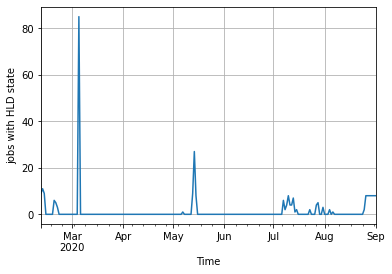

In [27]:
job_logs[job_logs['STT']=='HLD'].set_index('Time')['Identifier'].resample('D').nunique().plot()
plt.grid(); plt.ylabel('jobs with HLD state')

In [28]:
job_logs.set_index('Identifier').loc['4993b9f181ffc499']

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 12:40:21+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 12:51:15+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:02:07+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:12:57+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:23:51+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:34:44+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:45:38+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:56:31+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 14:07:24+01:00,2020-02-06 19:52:28+01:00


### `POR` status
About 0.01% of the jobs have post-running status records. There are memory and CPU resource information, as well as elapse time records available. The elapse time record might be used to more accurately estimate the job duration, we therefore simplify by assigning a `RUN` state to these job log entries.

In [29]:
these_identifiers = job_logs[job_logs['STT']=='POR']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.5980990649872499

In [30]:
job_logs.set_index('Identifier').loc['e72bfd0bae1058bd']

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:12:25+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:23:03+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:33:42+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:44:18+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:54:52+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:05:29+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:16:07+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:26:45+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:37:24+01:00,2020-02-06 19:52:28+01:00


### `PRR` status
About 0.01% of the jobs have pre-running status records. This status appears at the transition from `QUE` to `RUN` state. No elapse time or CPU/memory resource information are available. This discontinuity should be taken into account for estimating the waiting time characteristics. To remove the discontinuity, we will manually assign the `QUE` status for these entries.

In [31]:
these_identifiers = job_logs[job_logs['STT']=='PRR']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.6429178579707905

In [32]:
with pd.option_context('display.max_rows', None):
    display(job_logs.set_index('Identifier').loc['8a29b474b7002d06'])

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:08:39+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:18:40+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:28:41+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:38:42+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:48:43+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:58:43+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:08:44+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:18:45+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:28:46+02:00,2020-03-03 11:32:54+01:00


### `STG` status
About 0.004% of the jobs have staging status records. This status appears between the `QUE` and `RUN` state. No elapse time or CPU/memory resource information are available. The discontinuity should be taken into account for estimating the waiting time, though. For simplicity, we will manually assign the `QUE` state for these job log entries.

In [33]:
these_identifiers = job_logs[job_logs['STT']=='STG']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.2287303917780697

In [34]:
job_logs.set_index('Identifier').loc['57fe9649cf6ede24']

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 21:55:25+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:05:26+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:15:27+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:25:28+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:35:29+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:45:30+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:55:31+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 23:05:32+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 23:15:33+02:00,2020-03-03 11:32:54+01:00


### `WAT` status
About 0.01% of the jobs have waiting status records. (See also considerations for the `HLD` job status.)

In [35]:
these_identifiers = job_logs[job_logs['STT']=='WAT']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.09272853720732556

Text(0, 0.5, 'jobs with WAT state')

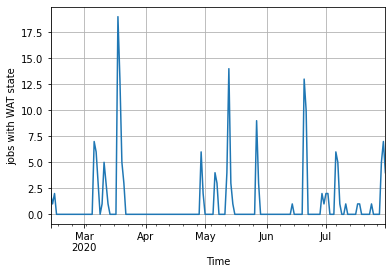

In [36]:
job_logs[job_logs['STT']=='WAT'].set_index('Time')['Identifier'].resample('D').nunique().plot()
plt.grid(); plt.ylabel('jobs with WAT state')

In [37]:
job_logs.set_index('Identifier').loc['0c270e0e2f5749a2']

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:22:36+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:33:33+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:44:32+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:55:34+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:06:35+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:17:42+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:28:38+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,RUN,1.01426,190.20,557.0,1.0,2020-02-13 14:39:35+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,RUN,2.77000,481.10,1225.0,1.0,2020-02-13 14:50:42+01:00,2020-02-06 19:52:28+01:00


### Apply the post-processing

In [38]:
job_logs.replace(to_replace='PRR', value='QUE', inplace=True)

In [39]:
job_logs.replace(to_replace='STG', value='QUE', inplace=True)

In [40]:
job_logs.replace(to_replace='POR', value='RUN', inplace=True)

In [41]:
drop_these = job_logs['STT']=='EXT'
job_logs.drop(job_logs.index[drop_these], inplace=True)

Check if only `QUE` and `RUN` states are left. (There won't.)

In [42]:
100*job_logs['STT'].value_counts()/len(job_logs)

RUN    51.774044
QUE    47.986919
HLD     0.158767
WAT     0.080270
Name: STT, dtype: float64

For now, remove only the `HLD` and `WAT` states from the jobs. (But see considerations at `HLD` job states.)

In [43]:
drop_these = (job_logs.set_index('Identifier')['STT']=='HLD').index

In [44]:
drop_these = job_logs['STT']=='HLD'
job_logs.drop(job_logs.index[drop_these], inplace=True)

In [45]:
drop_these = job_logs['STT']=='WAT'
job_logs.drop(job_logs.index[drop_these], inplace=True)

In [46]:
100*job_logs['STT'].value_counts()/len(job_logs)

RUN    51.8981
QUE    48.1019
Name: STT, dtype: float64

In [47]:
100*job_logs.shape[0]/orig_log_length, 100*job_logs['Identifier'].unique().shape[0]/orig_unique_jobs

(89.80154837854505, 94.50418428867093)

## Sampling error estimate
The sampling error is estimated based on those 34.2% of the jobs for which a transition from `QUE` into `RUN` state was recorded. It is on average 5:03 minutes, i.e. a little bit less than about half of the average log sampling interval. This value might be taken as estimate for the systematic underestimation of job waiting and processing times as calculated below.

In [48]:
100*((job_logs.groupby('Identifier')['STT'].value_counts().unstack()>0).sum(axis=1)>1).sum() \
   / job_logs['Identifier'].unique().shape[0]

34.20378172931197

In [49]:
grouped_que = job_logs[job_logs['STT']=='QUE'].groupby('Identifier')
grouped_run = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
sampling_bias = grouped_run['Time'].min() \
  - grouped_que['Time'].max() - pd.to_timedelta(grouped_run['Elapse'].min(), unit='s')

In [50]:
print(sampling_bias.mean())

0 days 00:05:03.948545446


Text(0.5, 0, 'Sampling error in minutes')

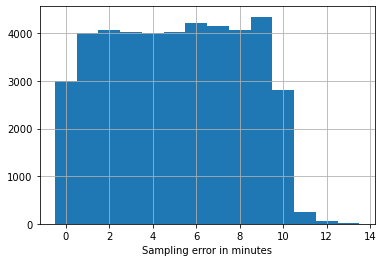

In [51]:
(sampling_bias.dt.total_seconds()/60).hist(bins=np.arange(-0.5,14,1))
plt.xlabel('Sampling error in minutes')

### Actual log sampling interval
Control of the log sampling is realised via a `sleep 10m` command. A drift might be caused by having implemented triggering of log records based on this approach. Also, because job logs are captured with Python and loading of the necessary software environment takes time, the actual log sampling interval might be larger. Indeed it is on average about 11:28 minutes.

In [52]:
sampling_interval = pd.Series(job_logs['Time'].unique()).diff()
print(sampling_interval.mean())

0 days 00:11:28.210808338


Text(0.5, 0, 'actual sampling interval in minutes')

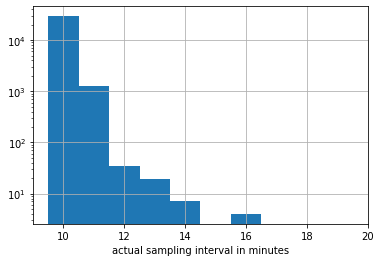

In [53]:
sampling_interval.dt.total_seconds().div(60).hist(bins=np.arange(9.5,20,1))
plt.yscale('log'); plt.xlabel('actual sampling interval in minutes')

## Job characteristics

### Batch class

In [54]:
job_batch_class = job_logs.groupby('Identifier')['Queue'].unique()

In [55]:
job_batch_class = job_batch_class.apply(lambda x: x[0])

### Submit date
This is a biased quantity. Taken as first appearance of a job in the logs. There is no straightforward way of correcting it. Because of that, waiting times will be systematically underestimated.

In [56]:
grouped_que = job_logs[job_logs['STT']=='QUE'].groupby('Identifier')
job_submission_date = grouped_que['Time'].min()

### Starting date
Also biased, but a correction based on the elapse time record can be applied.

In [57]:
grouped_run = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
sampling_error = pd.to_timedelta(grouped_run['Elapse'].min(), unit='s')
job_start_date = grouped_run['Time'].min()-sampling_error

#### Starting date sampling error

Text(0.5, 0, 'Sampling error in minutes')

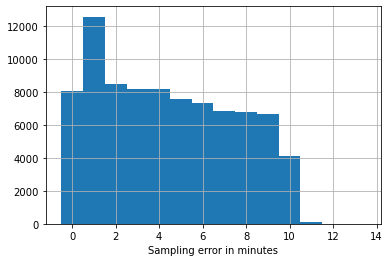

In [58]:
sampling_error.dt.total_seconds().div(60).hist(bins=np.arange(-0.5,14,1))
plt.xlabel('Sampling error in minutes')

### Waiting time
The most accurate estimate can be obtained based on the job submit and job start date estimated above. Not for all jobs a run period was detected, though. For these jobs waiting times can still be estimated from the start and end date associated with a job's waiting period. The error of this estimate might be twice the error of the date-based estimate though, as uncorrected sampling errors occur both at the beginning and end of the waiting period. Apparently, for about 33.2% of the jobs no waiting times are detected at all.

In [59]:
job_waited = (job_start_date-job_submission_date).dt.total_seconds()/60

In [60]:
100*job_waited.isna().value_counts()/job_waited.size

True     65.796218
False    34.203782
dtype: float64

In [61]:
grouped_que = job_logs[job_logs['STT']=='QUE'].groupby('Identifier')
job_waited_no_run = grouped_que['Time'].max()-grouped_que['Time'].min()
job_waited_no_run = job_waited_no_run.dt.total_seconds()/60

In [62]:
job_waited.fillna(value=job_waited_no_run, inplace=True)

In [63]:
100*job_waited.isna().value_counts()/job_waited.size

False    66.79283
True     33.20717
dtype: float64

### Duration
Note, due to sampling errors, there is a systematic underestimation for the job duration estimate as well.

In [64]:
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
job_duration = grouped['Elapse'].max()/60 # in minutes

### CPU and memory resources

In [65]:
job_logs['CPU_occ'] = job_logs['CPU']/job_logs['Elapse']
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')

In [66]:
job_cpu = grouped['CPU_occ'].max()

In [67]:
job_cpu_range = grouped['CPU_occ'].quantile([0.025, 0.975]).unstack().diff(axis=1) \
    .rename({0.975:'delta_CPU'}, axis='columns').drop(columns=0.025)

In [68]:
job_memory = grouped['Memory'].max()

In [69]:
job_memory_range = grouped['Memory'].quantile([0.025, 0.975]).unstack().diff(axis=1) \
    .rename({0.975:'delta_Memory'}, axis='columns').drop(columns=0.025)

### Nodes per job

In [70]:
job_nodes = job_logs.groupby('Identifier')['Jobs'].mean()

## Construct dataframe

In [71]:
derived_data = {'Batch_class': job_batch_class,
                'Submission_date': job_submission_date,
                'Waited': job_waited,
                'Start_date': job_start_date,
                'Duration': job_duration,
                'Nodes': job_nodes,
                'CPU': job_cpu,
                'Memory': job_memory,
                }

In [72]:
job_chars = pd.DataFrame(data=derived_data)

In [73]:
job_chars = pd.concat([job_chars, job_cpu_range, job_memory_range], axis=1)

In [74]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
0002286e1d7e428d,clmedium,NaT,NaN,2020-09-28 07:55:47+02:00,60.716667,1.0,0.989072,0.04895,0.502306,0.005687
00024ec1bf68e413,clfo2,NaT,NaN,2020-06-29 01:05:19+02:00,0.116667,1.0,0.000000,0.00000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000
fffd086716a4d46c,cllong,NaT,NaN,2020-09-14 00:40:27+02:00,143.616667,1.0,0.994714,0.46693,0.025502,0.000300
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000
ffff662620b8e573,clmedium,2020-06-12 00:00:38+02:00,65.850000,2020-06-12 01:06:29+02:00,304.666667,1.0,12.844902,14.81000,5.739389,8.583503


## Manual corrections

In [75]:
correct_dates = (job_chars['Submission_date']<=job_chars['Start_date']) \
   | job_chars['Submission_date'].isna() | job_chars['Start_date'].isna()

In [76]:
correct_dates.value_counts()

True     126025
False         2
dtype: int64

In [78]:
job_chars[job_chars['Waited']<0]['Submission_date']-sampling_bias

000030ecd19c9c04   NaT
00020fcd04947084   NaT
0002286e1d7e428d   NaT
00024ec1bf68e413   NaT
00027e89035bec8d   NaT
                    ..
fffbfaccf8c9fbf4   NaT
fffd086716a4d46c   NaT
ffff38341e8c6b3b   NaT
ffff662620b8e573   NaT
ffffddf606283b7b   NaT
Length: 126027, dtype: datetime64[ns, Europe/Berlin]

In [79]:
job_chars[job_chars['Waited']<0]

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
452d3bf73f74fdc7,clfo2,2020-02-17 21:47:57+01:00,-0.016667,2020-02-17 21:47:56+01:00,10.116667,1.0,0.631005,15.61000,0.000000,0.000000
6940fa7dd90857a1,cllong,2020-05-28 23:24:17+02:00,-0.883333,2020-05-28 23:23:24+02:00,40.966667,1.0,0.983763,0.14954,0.029739,0.009917


In [80]:
job_chars['Waited'].min(),job_chars['Waited'].max(),job_chars['Waited'].isna().sum()

(-0.8833333333333333, 25953.916666666668, 41850)

In [81]:
job_chars['Duration'].min(),job_chars['Duration'].max(),job_chars['Duration'].isna().sum()

(0.0, 23999.283333333333, 41071)

## Store on disk

In [82]:
job_chars.to_parquet('data/job_chars.parquet', compression='gzip')

In [83]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
0002286e1d7e428d,clmedium,NaT,NaN,2020-09-28 07:55:47+02:00,60.716667,1.0,0.989072,0.04895,0.502306,0.005687
00024ec1bf68e413,clfo2,NaT,NaN,2020-06-29 01:05:19+02:00,0.116667,1.0,0.000000,0.00000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000
fffd086716a4d46c,cllong,NaT,NaN,2020-09-14 00:40:27+02:00,143.616667,1.0,0.994714,0.46693,0.025502,0.000300
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000
ffff662620b8e573,clmedium,2020-06-12 00:00:38+02:00,65.850000,2020-06-12 01:06:29+02:00,304.666667,1.0,12.844902,14.81000,5.739389,8.583503


## Appendix

In [84]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/git-lfs-2.11.0-0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/nomkl-1.0-h5ca1d4c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.6.20-hecda079_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.35-h769bd43_9.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran5-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.3.0-h2ae2ef3_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.11.0.4-hd18ef5c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgomp-9.3.0-h5dbcf3e_17.tar.bz2
https://conda.anacon